In [1]:
#!pip install spacy
#!python -m spacy download en_core_web_trf
#!pip install vaderSentiment
#!pip install textblob
#!pip install pdfplumber

In [2]:
import pandas as pd
import numpy as np
import re
import pdfplumber
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
import nltk
#nltk.download('stopwords')

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Cleaning the text

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

In [5]:
# "starbucks_2023.txt" and "starbucks_2024.txt" contains Item 1, 1A, 7, 7A in the 2023/2024 10-k
filepath_2023 = r'C:\Users\ariel\OneDrive\Documents\UCSD\423 Data Science\final project-starbucks\starbucks_2023.txt'
filepath_2024 = r'C:\Users\ariel\OneDrive\Documents\UCSD\423 Data Science\final project-starbucks\starbucks_2024.txt'

with open(filepath_2023, 'r', encoding='utf-8') as f: 
    text_2023 = preprocess_text(f.read())
with open(filepath_2024, 'r', encoding='utf-8') as f: 
    text_2024 = preprocess_text(f.read())

print("\nSample from 2023 report:")
print(text_2023[:500])


Sample from 2023 report:
item 1 business
general
in this annual report on form 10k 10k or report for the fiscal year ended october 1 2023 fiscal 2023 starbucks corporation together with its
subsidiaries is referred to as starbucks the company we us or our
starbucks is the premier roaster marketer and retailer of specialty coffee in the world operating in 86 markets formed in 1985 starbucks corporations
common stock trades on the nasdaq global select market nasdaq under the symbol sbux we purchase and roast highquality c


In [6]:
# Apply spaCy NLP processing
nlp = spacy.load("en_core_web_trf")

doc_2023 = nlp(text_2023)
doc_2024 = nlp(text_2024)

# Analysis

## Q1: How does Starbucks describe the impact of coffee bean price fluctuations and it strategy to manage them? 
## Q2: How did supply chain disruptions affact Starbucks? How did Starbucks react?

In [9]:
# "starbucks_2023_risk.txt" and "starbucks_2024_risk.txt" contains Item 1A in the 2023/2024 10-k
filepath_2023_risk = r"C:\Users\ariel\OneDrive\Documents\UCSD\423 Data Science\final project-starbucks\starbucks_2023_risk.txt"
filepath_2024_risk = r"C:\Users\ariel\OneDrive\Documents\UCSD\423 Data Science\final project-starbucks\starbucks_2024_risk.txt"

In [10]:
with open(filepath_2023_risk, 'r', encoding='utf-8') as f: 
    text_2023_risk = preprocess_text(f.read())
with open(filepath_2024_risk, 'r', encoding='utf-8') as f: 
    text_2024_risk = preprocess_text(f.read())

In [11]:
doc_2023_risk = nlp(text_2023_risk)
doc_2024_risk = nlp(text_2024_risk)

In [12]:
def answer_question(doc, question, context_window=5):
    question_doc = nlp(question)
    key_terms = [token.text.lower() for token in question_doc 
                if not token.is_stop and not token.is_punct and token.pos_ in ('NOUN', 'PROPN', 'VERB', 'ADJ')]
    
    if "price fluctuations" in question.lower():
        key_terms.extend(['price', 'fluctuation', 'cost', 'commodity', 'coffee bean', 'coffee', 'risk'])
    if "supply chain" in question.lower():
        key_terms.extend(['supply', 'chain', 'disruption', 'logistics', 'inventory', 'shortage'])
    
    relevant_sentences = []
    sentences = list(doc.sents)
    
    for i, sent in enumerate(sentences):
        sent_text = sent.text.lower()
        
        if any(term.lower() in sent_text for term in key_terms):
            # Get surrounding sentences for context
            start = max(0, i - context_window)
            end = min(len(sentences), i + context_window + 1)
            
            context = " ".join([sentences[j].text for j in range(start, end)])
            relevant_sentences.append(context)
    
    return relevant_sentences

### Analyze 2023 report

In [14]:
q1 = "How does Starbucks describe the impact of coffee bean price fluctuations and its strategies to manage them?"
q2 = "How did supply chain disruptions affect Starbucks? How did Starbucks react?"

answers_q1 = answer_question(doc_2023_risk, q1)
answers_q2 = answer_question(doc_2023_risk, q2)

max_lines = 2
print("Question 1 Findings:")
for i, answer in enumerate(answers_q1):
    lines = answer.split("\n")  # Split answer into lines
    limited_answer = "\n".join(lines[:max_lines])
    print(f"Finding {i+1}:\n{limited_answer}")
    if len(lines) > max_lines:
        print("... [truncated]\n")

print("\nQuestion 2 Findings:")
for i, answer in enumerate(answers_q2):
    lines = answer.split("\n")  # Split answer into lines
    limited_answer = "\n".join(lines[:max_lines])
    print(f"Finding {i+1}:\n{limited_answer}")
    if len(lines) > max_lines:
        print("... [truncated]\n")

Question 1 Findings:
Finding 1:
item 1a risk factors 
 you should carefully consider the risks described below in addition to the other information set forth in this annual report on form 10k including the
... [truncated]

Finding 2:
item 1a risk factors 
 you should carefully consider the risks described below in addition to the other information set forth in this annual report on form 10k including the
... [truncated]

Finding 3:
item 1a risk factors 
 you should carefully consider the risks described below in addition to the other information set forth in this annual report on form 10k including the
... [truncated]

Finding 4:
you should carefully consider the risks described below in addition to the other information set forth in this annual report on form 10k including the
managements discussion and analysis of financial conditions and results of operations section the quantitative and qualitative disclosures about market
... [truncated]

Finding 5:
we do not monitor the quality o

In [15]:
entities = [(ent.text, ent.label_) for ent in doc_2023_risk.ents 
            if ent.label_ in ['ORG', 'MONEY', 'PERCENT', 'DATE', 'PRODUCT']]

# Find sentences containing these entities and relevant keywords
coffee_price_sentences = []
for sent in doc_2023_risk.sents:
    if any(term in sent.text.lower() for term in ['coffee', 'price', 'cost', 'commodity']):
        coffee_price_sentences.append(sent.text)

with open('coffee_price_sentences.txt', 'w', encoding='utf-8') as f:
    for sentence in coffee_price_sentences:
        f.write(sentence + '\n')

In [16]:
supply_chain_sentences = []
for sent in doc_2023_risk.sents:
    if any(term in sent.text.lower() for term in ['supply', 'chain', 'disruption', 'logistics', 'inventory', 'shortage']):
        supply_chain_sentences.append(sent.text)

with open('supply_chain_sentences.txt', 'w', encoding='utf-8') as f:
    for sentence in supply_chain_sentences:
        f.write(sentence + '\n')

### Repeat above analysis for 2024 report

In [18]:
q1 = "How does Starbucks describe the impact of coffee bean price fluctuations and its strategies to manage them?"
q2 = "How did supply chain disruptions affect Starbucks? How did Starbucks react?"

answers_q1 = answer_question(doc_2024_risk, q1)
answers_q2 = answer_question(doc_2024_risk, q2)

print("Question 1 Findings:")
for i, answer in enumerate(answers_q1):
    print(f"Finding {i+1}:\n{answer}\n")

print("\nQuestion 2 Findings:")
for i, answer in enumerate(answers_q2):
    print(f"Finding {i+1}:\n{answer}\n")

Question 1 Findings:
Finding 1:
item 1a risk factors 
you should carefully consider the risks described below in addition to the other information set forth in this annual report on form 10k including the
managements discussion and analysis of financial conditions and results of operations section the quantitative and qualitative disclosures about market
risk section and the consolidated financial statements and related notes the risks described below are not the only risks facing the company risks and
uncertainties not currently known to us or that we currently deem to be immaterial also may materially adversely affect our business financial condition and
operating results
summary of risks associated with our business
our business is subject to various risks and uncertainties that you should consider before investing in the company these risks are described in more detail in
this item 1a these risks include but are not limited to the following
risks related to brand relevance and bran

In [19]:
# Extract entity information
entities = [(ent.text, ent.label_) for ent in doc_2024_risk.ents 
            if ent.label_ in ['ORG', 'MONEY', 'PERCENT', 'DATE', 'PRODUCT']]

# Find sentences containing these entities and relevant keywords
coffee_price_sentences = []
for sent in doc_2024_risk.sents:
    if any(term in sent.text.lower() for term in ['coffee', 'price', 'cost', 'commodity']):
        coffee_price_sentences.append(sent.text)

# Save sentences to a text file
with open('coffee_price_sentences.txt', 'w', encoding='utf-8') as f:
    for sentence in coffee_price_sentences:
        f.write(sentence + '\n')

In [20]:
supply_chain_sentences = []
for sent in doc_2024_risk.sents:
    if any(term in sent.text.lower() for term in ['supply', 'chain', 'disruption', 'logistics', 'inventory', 'shortage']):
        supply_chain_sentences.append(sent.text)

with open('supply_chain_sentences.txt', 'w', encoding='utf-8') as f:
    for sentence in supply_chain_sentences:
        f.write(sentence + '\n')

## Q3: What’s the sentiment tongue of 2023 and 2024 Starbucks Annual Reports? 

In [22]:
# "starbucks_2023_discussion.txt" and "starbucks_2024_discussion.txt" contains Item 7 in the 2023/2024 10-k
filepath_2023_discussion = r"C:\Users\ariel\OneDrive\Documents\UCSD\423 Data Science\final project-starbucks\starbucks_2023_discussion.txt"
filepath_2024_discussion = r"C:\Users\ariel\OneDrive\Documents\UCSD\423 Data Science\final project-starbucks\starbucks_2024_discussion.txt"

In [23]:
with open(filepath_2023_discussion, 'r', encoding='utf-8') as f: 
    text_2023_discussion = preprocess_text(f.read())
with open(filepath_2024, 'r', encoding='utf-8') as f: 
    text_2024_discussion = preprocess_text(f.read())

In [24]:
doc_2023_discussion = nlp(text_2023_discussion)
doc_2024_discussion = nlp(text_2024_discussion)

In [25]:
# Adding stop words
def preprocess_text2(text):
    business_stop_words = {'may', 'including', 'business', 'company', 'fiscal', 'year', 'please', 'refer', 
                           'note', 'result', 'results', 'increase', 'decrease', 'change', 'approximately'}
        
    stop_words = set(stopwords.words('english'))
    stop_words.update(business_stop_words)
    
    words = [token.text for token in text]  
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(filtered_words)

cleaned_2023 = preprocess_text2(doc_2023_discussion)
cleaned_2024 = preprocess_text2(doc_2024_discussion)

In [26]:
# Analyze sentiment for 2023 and 2024 using VADER
analyzer = SentimentIntensityAnalyzer()

vader_2023 = analyzer.polarity_scores(cleaned_2023)
vader_2024 = analyzer.polarity_scores(cleaned_2024)

print("Sentiment Scores for 2023:", vader_2023)
print("Sentiment Scores for 2024:", vader_2024)

Sentiment Scores for 2023: {'neg': 0.045, 'neu': 0.759, 'pos': 0.195, 'compound': 1.0}
Sentiment Scores for 2024: {'neg': 0.092, 'neu': 0.736, 'pos': 0.172, 'compound': 1.0}


In [27]:
# Analyze sentiment for 2023 and 2024 using textblob
textblob_2023 = TextBlob(cleaned_2023).sentiment
textblob_2024 = TextBlob(cleaned_2024).sentiment

print("TextBlob Sentiment for 2023:", textblob_2023)
print("TextBlob Sentiment for 2024:", textblob_2024)

TextBlob Sentiment for 2023: Sentiment(polarity=0.08446981915933531, subjectivity=0.3492283442364093)
TextBlob Sentiment for 2024: Sentiment(polarity=0.06322396367577085, subjectivity=0.3624985084824423)


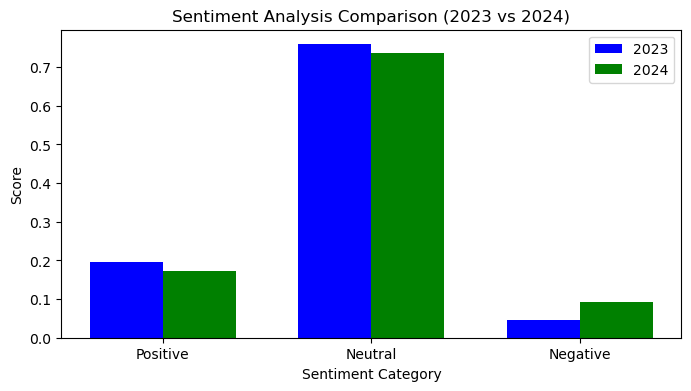

In [28]:
# Visualization
labels = ['Positive', 'Neutral', 'Negative']
values_2023 = [vader_2023['pos'], vader_2023['neu'], vader_2023['neg']]
values_2024 = [vader_2024['pos'], vader_2024['neu'], vader_2024['neg']]

x = np.arange(len(labels))
width = 0.35  

fig, ax = plt.subplots(figsize=(8, 4))
rects1 = ax.bar(x - width/2, values_2023, width, label="2023", color="blue")
rects2 = ax.bar(x + width/2, values_2024, width, label="2024", color="green")

ax.set_xlabel("Sentiment Category")
ax.set_ylabel("Score")
ax.set_title("Sentiment Analysis Comparison (2023 vs 2024)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

## Q4: What’s the performance difference between 2023 & 2024? 

In [30]:
# Add stopwords for financial and business reports
custom_stopwords = set(["business", "company", "general", "annual", "report", "form", "fiscal", "year", "end", "subsidiary", "refer", 
                        "market", "customer", "share", "value", "financial", "management", "statement", "data", "service", "corporation", 
                        "include", "premier", "retailer", "marketer", "specialty", "coffee", "world", "item", "starbucks", "sbux", "starbucks corporation"])

# Extract key nouns, verbs, and adjectives
def extract_keywords(doc):
    return [token.lemma_ for token in doc if token.pos_ in ['VERB', 'ADJ'] and not token.is_stop and token.lemma_ not in custom_stopwords]

keywords_2023 = extract_keywords(doc_2023)
keywords_2024 = extract_keywords(doc_2024)

print("\nSample extracted keywords from 2023 report:")
print(keywords_2023[:20])  # Show first 20 keywords
print("\nSample extracted keywords from 2024 report:")
print(keywords_2024[:20])  # Show first 20 keywords


Sample extracted keywords from 2023 report:
['operate', 'common', 'trade', 'purchase', 'roast', 'highquality', 'sell', 'handcrafted', 'highquality', 'companyoperated', 'sell', 'license', 'licensed', 'sell', 'follow', 'primary', 'maintain', 'recognized', 'respected', 'believe']

Sample extracted keywords from 2024 report:
['operate', 'common', 'trade', 'purchase', 'roast', 'highquality', 'sell', 'handcrafted', 'highquality', 'companyoperated', 'sell', 'license', 'license', 'sell', 'follow', 'primary', 'maintain', 'recognize', 'respected', 'believe']


In [31]:
# Combine keywords back into text for TF-IDF
corpus = [" ".join(keywords_2023), " ".join(keywords_2024)]

# Compute TF-IDF
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(corpus)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=['2023', '2024'], columns=vectorizer.get_feature_names_out())

print("\nTF-IDF Matrix:")
print(tfidf_df.head())


TF-IDF Matrix:
          able    access   account  accurate   achieve       act    actual  \
2023  0.030509  0.015254  0.007627  0.011441  0.045763  0.015254  0.019068   
2024  0.025551  0.012775  0.006388  0.012775  0.038326  0.012775  0.012775   

         adapt       add  additional  ...    useful   utilize  variable  \
2023  0.011441  0.003814    0.114409  ...  0.015254  0.015254  0.011441   
2024  0.012775  0.015969    0.089427  ...  0.009582  0.012775  0.009582   

          vary   welcome  welcoming  wellestablished      wide      work  \
2023  0.030509  0.011441   0.015254         0.007627  0.015254  0.068645   
2024  0.028745  0.009582   0.009582         0.006388  0.015969  0.063877   

       working  
2023  0.007627  
2024  0.009582  

[2 rows x 500 columns]


In [32]:
# Compute term importance difference (2024 - 2023)
tfidf_diff = tfidf_df.loc['2024'] - tfidf_df.loc['2023']
tfidf_diff_sorted = tfidf_diff.sort_values(ascending=False)

# Extract top 20 increased and decreased terms
top_increased = tfidf_diff_sorted.head(20)
top_decreased = tfidf_diff_sorted.tail(20)

print("\nTop 20 Increased Terms in 2024:")
print(top_increased)
print("\nTop 20 Decreased Terms in 2024:")
print(top_decreased)


Top 20 Increased Terms in 2024:
certain        0.051861
legal          0.037181
continue       0.034462
impact         0.033842
affect         0.030503
unable         0.028839
negative       0.028504
incur          0.026980
meet           0.024501
second         0.024311
improve        0.023691
chief          0.023261
offset         0.022642
harm           0.021307
social         0.018828
operate        0.018063
collective     0.017955
substantial    0.017923
current        0.017588
reflect        0.017304
dtype: float64

Top 20 Decreased Terms in 2024:
domestic             -0.013825
believe              -0.014255
commercial           -0.014445
governmental         -0.015065
corporate            -0.015495
elevate              -0.017114
total                -0.017259
companyoperated      -0.017974
experience           -0.019498
inflationary         -0.019688
foreign              -0.020883
store                -0.020927
fair                 -0.021787
international        -0.023982
addit

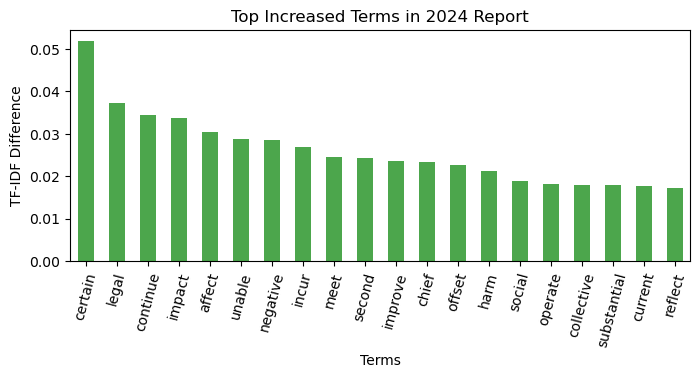

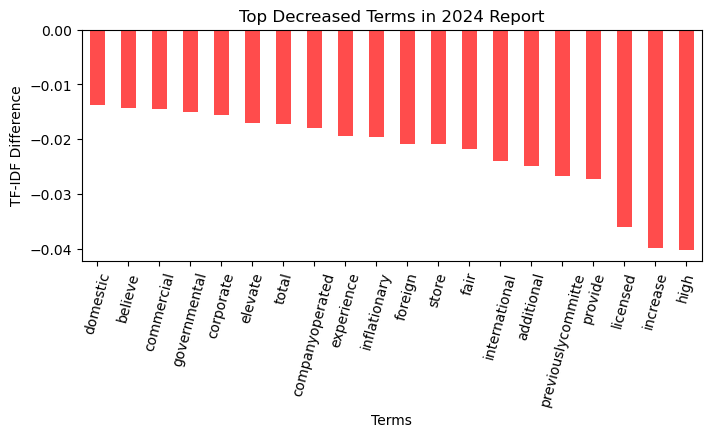

In [33]:
# Visualize TF-IDF Differences
plt.figure(figsize=(8, 3))
top_increased.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top Increased Terms in 2024 Report')
plt.xlabel('Terms')
plt.ylabel('TF-IDF Difference')
plt.xticks(rotation=75)
plt.show()

plt.figure(figsize=(8, 3))
top_decreased.plot(kind='bar', color='red', alpha=0.7)
plt.title('Top Decreased Terms in 2024 Report')
plt.xlabel('Terms')
plt.ylabel('TF-IDF Difference')
plt.xticks(rotation=75)
plt.show()

## Q5: What is Starbucks' environmental promise?

In [35]:
def extract_text_from_pdf(pdf_path):
    full_text = []
    
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:

            header_height = page.height * 0.15
            footer_height = page.height * 0.10
            cropped_page = page.crop((
                0, 
                header_height, 
                page.width, 
                page.height - footer_height
            ))
            text = cropped_page.extract_text()
            if text:
                # Remove common distractions such as page numbers
                text = re.sub(r'Page\s*\d+', '', text, flags=re.IGNORECASE)
                full_text.append(text)
    return "\n".join(full_text)

In [36]:
pdf_path = r"C:\Users\ariel\OneDrive\Documents\UCSD\423 Data Science\final project-starbucks\FY2023-Starbucks-Global-Impact-Report.pdf"
report_text = extract_text_from_pdf(pdf_path)
doc = nlp(report_text)

In [37]:
environmental_keywords = {
    "action_verbs": ["commit", "pledge", "aim", "strive", "target"],
    "environmental_terms": ["carbon neutral", "renewable energy", "sustainable packaging","water stewardship", 
                            "waste reduction", "circular economy", "climate positive", "resource positive", 
                            "greenhouse gas","sustainable agriculture", "deforestation-free"],
    "temporal_terms": ["by 2030", "by 2025", "by 2050", "five-year plan"]
}

promise_sentences = []

for sent in doc.sents:
    sent_text = sent.text.lower()

    # combination of verbs + environmental terms
    verb_match = any(v in sent_text for v in environmental_keywords["action_verbs"])
    env_match = any(e in sent_text for e in environmental_keywords["environmental_terms"])
    time_match = any(t in sent_text for t in environmental_keywords["temporal_terms"])

    # contain verb and environment terms, time terms are optional
    if verb_match and env_match:
        clean_sent = re.sub(r'\s+', ' ', sent.text.strip())
        clean_sent = clean_sent[0].upper() + clean_sent[1:]
        
        if len(clean_sent.split()) > 15:
            sub_sents = [s.text for s in nlp(clean_sent).sents]
            promise_sentences.extend(sub_sents)
        else:
            promise_sentences.append(clean_sent)

In [38]:
# De-duplication and Sorting
unique_sentences = []
seen = set()
for sent in promise_sentences:
    key = re.sub(r'[^a-zA-Z]', '', sent.lower())
    if key not in seen:
        seen.add(key)
        unique_sentences.append(sent)

environmental_promises = sorted(unique_sentences, 
    key=lambda x: any(t in x.lower() for t in environmental_keywords["temporal_terms"]), 
    reverse=True)[:5]

In [39]:
print(f"Identified Key Commitments ({len(environmental_promises)})")
print("-"*60)
for idx, promise in enumerate(environmental_promises, 1):
    if not promise.endswith(('.', '!', '?')):
        promise += '.'
    print(f"[Commitment {idx}] {promise}\n")

Identified Key Commitments (5)
------------------------------------------------------------
[Commitment 1] By 2030, Starbucks is aiming to achieve.

[Commitment 2] Since making the commitment to distribute 100 million coffee SUSTAINABLE AGRICULTURE FY23 trees by 2025, Starbucks has now distributed more than 80 million of the next generation of climate-resistant coffee # soil samples processed (cumulative as of FYE) >30,800 trees in El Salvador, Guatemala and Mexico.

[Commitment 3] % of customer packaging made from recycled or renewable materials 24% 23% % change in total water withdrawal from FY19 baseline -9% -9% Goal: 100% of Starbucks customer packaging will be reusable, recyclable, or compostable by 2030.

[Commitment 4] carbon-neutral green Water stewardship and soil health are important.

[Commitment 5] To further advance our transparency, we will conduct a material biodiversity impact assessment with respect to our coffee supply chain, to be completed by the end Climate-resista